In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.feature_extractor import SIFT

# --- Load dataset info ---
with open('office_dataset_aruco/ground_truth_poses.json', 'r') as f:
    ground_truth = json.load(f)



camera_intrinsics = ground_truth["camera_intrinsics"]
K = np.array([[camera_intrinsics["fx"], 0, camera_intrinsics["cx"]],
              [0, camera_intrinsics["fy"], camera_intrinsics["cy"]],
              [0, 0, 1]], dtype=np.float32)


print("Number of frames:", len(ground_truth['poses']))


Number of frames: 121


In [2]:
# Look at the first frame
first_frame = ground_truth['poses'][0]
print("Frame:", first_frame['frame'])
print("Timestamp:", first_frame['timestamp'])

# Extract left camera pose (ignoring right camera for now)
left_cam = first_frame['left_camera']
translation = np.array(left_cam['translation'])
rotation_matrix = np.array(left_cam['rotation_matrix'])

print("\nTranslation:", translation)
print("\nRotation matrix:")
print(rotation_matrix)


Frame: 1
Timestamp: 0.03333333333333333

Translation: [ 4.         -0.06        1.79999995]

Rotation matrix:
[[ 7.54979013e-08 -4.10364658e-01  9.11921501e-01]
 [ 1.00000000e+00 -3.35693748e-08 -9.78961268e-08]
 [ 7.07857453e-08  9.11921501e-01  4.10364658e-01]]


In [3]:
# Let's understand what this rotation matrix represents
R = rotation_matrix
print("Rotation matrix determinant:", np.linalg.det(R))
print("Is orthogonal?", np.allclose(R @ R.T, np.eye(3)))

# Extract the camera's forward direction (3rd column in camera-to-world)
# or (3rd row in world-to-camera)
forward_dir = R[:, 2]  # 3rd column
print("\nForward direction (3rd column):", forward_dir)
print("Forward direction (3rd row):", R[2, :])

# Camera position
print("\nCamera position:", translation)

Rotation matrix determinant: 0.9999999765176826
Is orthogonal? True

Forward direction (3rd column): [ 9.11921501e-01 -9.78961268e-08  4.10364658e-01]
Forward direction (3rd row): [7.07857453e-08 9.11921501e-01 4.10364658e-01]

Camera position: [ 4.         -0.06        1.79999995]


In [4]:
# The forward direction (3rd column) is [0.912, ~0, 0.410]
# This means the camera is looking primarily in +X direction with some +Z component
forward_3rd_col = R[:, 2]
print("Forward direction from 3rd column:", forward_3rd_col)
print("Normalized:", forward_3rd_col / np.linalg.norm(forward_3rd_col))

# Let's also check what direction the camera's up vector points
up_direction = R[:, 1]  # 2nd column 
print("\nUp direction (2nd column):", up_direction)

# And right direction
right_direction = R[:, 0]  # 1st column
print("Right direction (1st column):", right_direction)

Forward direction from 3rd column: [ 9.11921501e-01 -9.78961268e-08  4.10364658e-01]
Normalized: [ 9.11921512e-01 -9.78961279e-08  4.10364662e-01]

Up direction (2nd column): [-4.10364658e-01 -3.35693748e-08  9.11921501e-01]
Right direction (1st column): [7.54979013e-08 1.00000000e+00 7.07857453e-08]


In [5]:
# Based on the directions, this confirms camera-to-world transform:
# - Right direction is nearly pure +Y [0, 1, 0] 
# - Forward direction points toward +X,+Z 
# - Camera position [4, -0.06, 1.8] makes sense

print("Coordinate system: Camera-to-World transform")
print("Camera position in world:", translation)
print("Camera looking direction:", forward_3rd_col)

# Extract camera intrinsics matrix
intrinsics = ground_truth['camera_intrinsics']
K = np.array([
    [intrinsics['fx'], 0, intrinsics['cx']],
    [0, intrinsics['fy'], intrinsics['cy']], 
    [0, 0, 1]
])

print("\nCamera intrinsics matrix K:")
print(K)
print("Image resolution:", intrinsics['resolution'])

Coordinate system: Camera-to-World transform
Camera position in world: [ 4.         -0.06        1.79999995]
Camera looking direction: [ 9.11921501e-01 -9.78961268e-08  4.10364658e-01]

Camera intrinsics matrix K:
[[1.28e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.28e+03 4.80e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Image resolution: [1280, 960]


In [6]:
# Let's look at a few frames to pick good ones
frames_to_check = [0, 4, 9, 14]  # frames 1, 5, 10, 15

print("Frame positions and orientations:")
for i in frames_to_check:
    frame = ground_truth['poses'][i]
    pos = np.array(frame['left_camera']['translation'])
    forward = np.array(frame['left_camera']['rotation_matrix'])[:, 2]
    
    print(f"Frame {frame['frame']}: pos={pos}, forward={forward[:2]}")  # Just X,Y of forward

Frame positions and orientations:
Frame 1: pos=[ 4.         -0.06        1.79999995], forward=[ 9.11921501e-01 -9.78961268e-08]
Frame 5: pos=[3.92506528 0.77295786 1.79999995], forward=[0.89199388 0.18959902]
Frame 10: pos=[3.59126544 1.7625016  1.79999995], forward=[0.81252813 0.41400364]
Frame 15: pos=[3.01272702 2.63193393 1.79999995], forward=[0.67768967 0.61019486]


Map building frames:
  Frame 1: [ 4.         -0.06        1.79999995]
  Frame 5: [3.92506528 0.77295786 1.79999995]
  Frame 10: [3.59126544 1.7625016  1.79999995]

Query frame 15: [3.01272702 2.63193393 1.79999995]


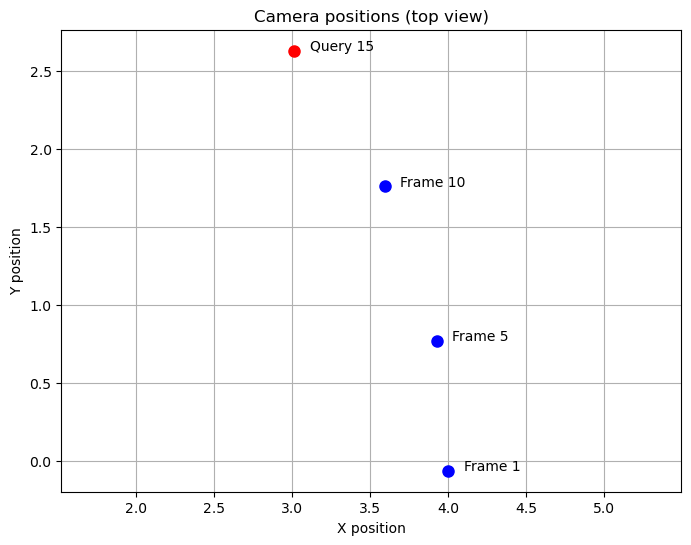

In [7]:
# Perfect! The camera is moving in an arc - good for triangulation
# Let's use frames 1, 5, 10 for map building and frame 15 for query

map_frames = [0, 4, 9]  # indices for frames 1, 5, 10
query_frame = 14        # index for frame 15

print("Map building frames:")
for i in map_frames:
    frame = ground_truth['poses'][i]
    pos = np.array(frame['left_camera']['translation'])
    print(f"  Frame {frame['frame']}: {pos}")

query_pos = np.array(ground_truth['poses'][query_frame]['left_camera']['translation'])
print(f"\nQuery frame {ground_truth['poses'][query_frame]['frame']}: {query_pos}")

# Plot camera positions (top-down view)
plt.figure(figsize=(8, 6))
for i in map_frames:
    pos = np.array(ground_truth['poses'][i]['left_camera']['translation'])
    plt.plot(pos[0], pos[1], 'bo', markersize=8)
    plt.text(pos[0]+0.1, pos[1], f"Frame {ground_truth['poses'][i]['frame']}")

plt.plot(query_pos[0], query_pos[1], 'ro', markersize=8)
plt.text(query_pos[0]+0.1, query_pos[1], f"Query {ground_truth['poses'][query_frame]['frame']}")
plt.xlabel('X position')
plt.ylabel('Y position') 
plt.title('Camera positions (top view)')
plt.grid(True)
plt.axis('equal')
plt.show()

In [8]:
import os

# Update this path to your images folder
images_path = "office_dataset_aruco/left"  # You need to fill this in

# Load the selected images
def load_image(frame_num):
    filename = f"frame_{frame_num:04d}.png"
    filepath = os.path.join(images_path, filename)
    img = cv2.imread(filepath)
    if img is None:
        print(f"Error: Could not load {filepath}")
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Load our selected frames
images = {}
for i, frame_idx in enumerate([0, 7, 9, 14]):  # frames 1, 5, 10, 15
    frame_num = ground_truth['poses'][frame_idx]['frame']
    img = load_image(frame_num)
    if img is not None:
        images[frame_num] = img
        print(f"Loaded frame {frame_num}: {img.shape}")

print(f"\nLoaded {len(images)} images")

Loaded frame 1: (960, 1280, 3)
Loaded frame 8: (960, 1280, 3)
Loaded frame 10: (960, 1280, 3)
Loaded frame 15: (960, 1280, 3)

Loaded 4 images


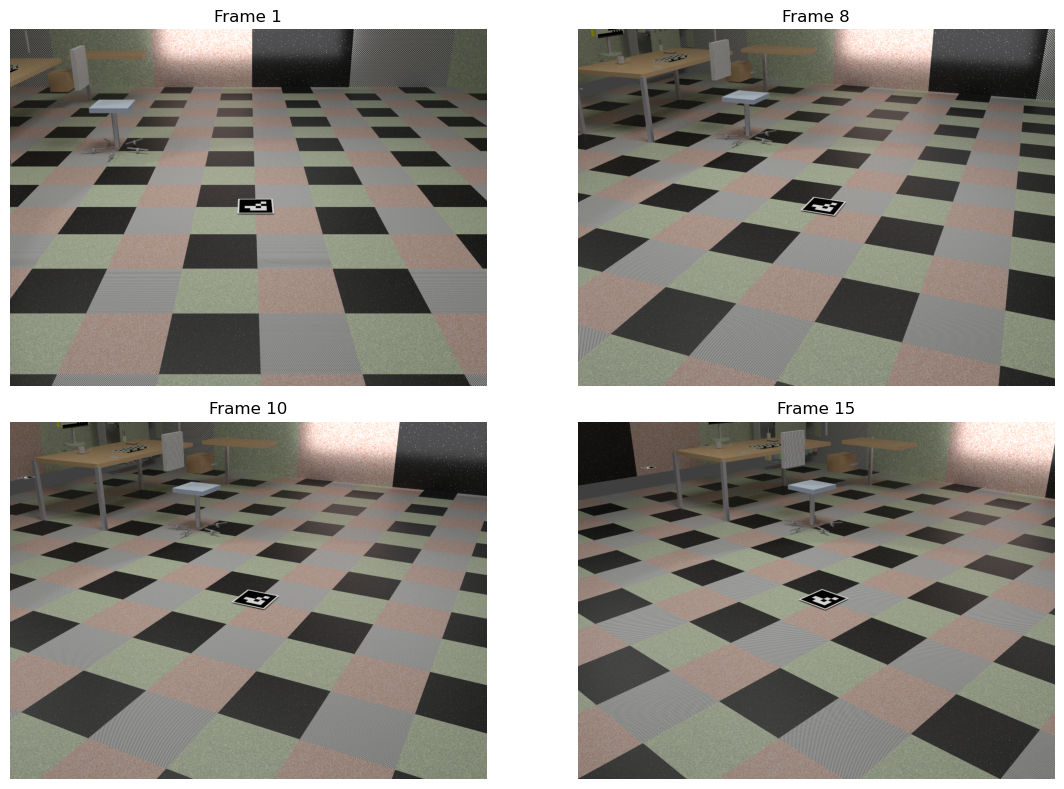

In [9]:
# --- Initialize feature extractor ---
extractor = SIFT(n_features=2000)

# display images
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
for i, (frame_num, img) in enumerate(images.items()):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Frame {frame_num}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Frame 1: 1601 keypoints, 1601 descriptors
Frame 8: 2000 keypoints, 2000 descriptors
Frame 10: 1437 keypoints, 1437 descriptors
Frame 15: 1491 keypoints, 1491 descriptors


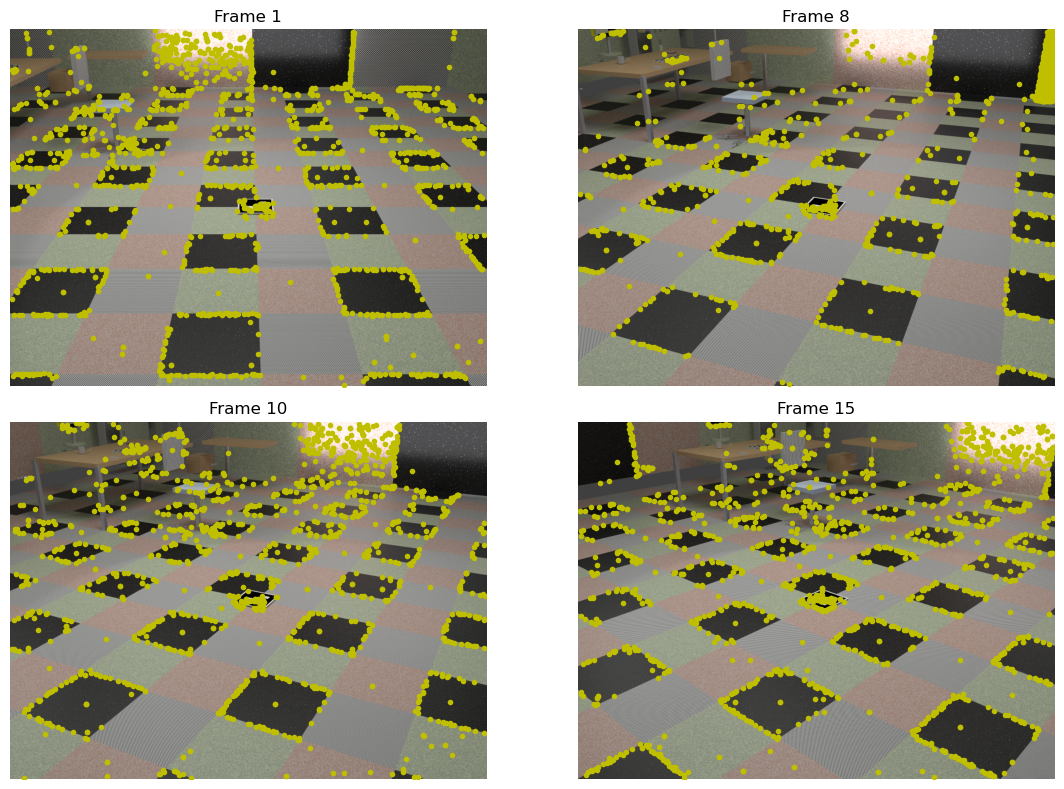

In [10]:
# Extract features and store in a better format
features = {}
plt.figure(figsize=(12, 8))

for i, (frame_num, img) in enumerate(images.items()):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Fixed: RGB to GRAY
    kp, desc = extractor.detect_and_compute(gray)
    
    # Store in dictionary for easier access
    features[frame_num] = {
        'keypoints': kp,
        'descriptors': desc,
        'image': img
    }
    
    print(f"Frame {frame_num}: {len(kp)} keypoints, {desc.shape[0] if desc is not None else 0} descriptors")
    
    # Visualize
    x1 = [p.pt[0] for p in kp]
    y1 = [p.pt[1] for p in kp]
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.plot(x1, y1, 'yo', markersize=3)
    plt.title(f"Frame {frame_num}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Match features between all map frame pairs (1-8, 1-10, 8-10)
map_frames = [1, 8, 10]
all_matches = {}

# Get descriptors
desc1 = features[1]['descriptors']
desc8 = features[8]['descriptors'] 
desc10 = features[10]['descriptors']

# Match all pairs
pairs = [
    ('1-8', desc1, desc8, 1, 8),
    ('1-10', desc1, desc10, 1, 10),
    ('8-10', desc8, desc10, 8, 10)
]

for pair_name, desc_a, desc_b, frame_a, frame_b in pairs:
    matches = extractor.match_features(desc_a, desc_b)
    
    # Extract point pairs
    pts_a, pts_b = [], []
    for match in matches:
        pt_a = features[frame_a]['keypoints'][match.queryIdx].pt
        pt_b = features[frame_b]['keypoints'][match.trainIdx].pt
        pts_a.append(pt_a)
        pts_b.append(pt_b)
    
    all_matches[pair_name] = (np.array(pts_a), np.array(pts_b), matches)
    print(f"Matches {pair_name}: {len(matches)}")

print("All point pairs extracted")

Matches 1-8: 142
Matches 1-10: 122
Matches 8-10: 164
All point pairs extracted


Pair 1-8: 126 matches after filtering (from 142)
Pair 1-10: 100 matches after filtering (from 122)
Pair 8-10: 160 matches after filtering (from 164)


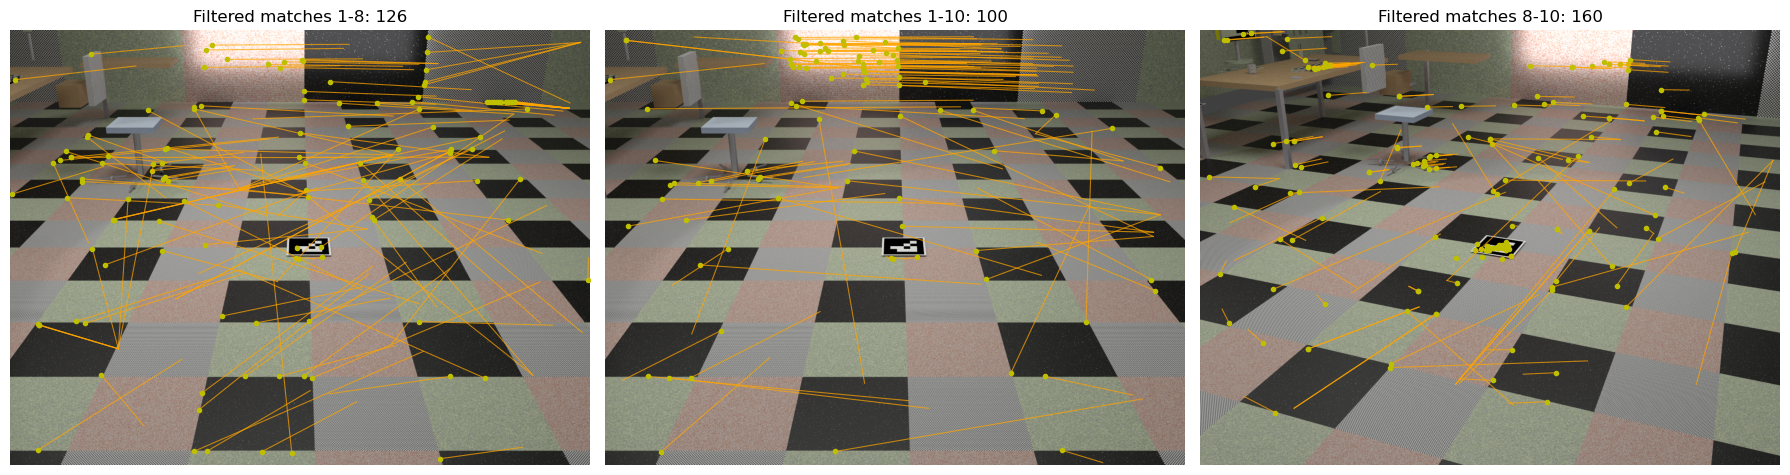

In [12]:
# Distance filtering for all three pairs
max_distance = 700
all_filtered_matches = {}

for pair_name, (pts_a, pts_b, raw_matches) in all_matches.items():
    filtered_matches = []
    for pa, pb in zip(pts_a, pts_b):
        distance = np.sqrt((pb[0]-pa[0])**2 + (pb[1]-pa[1])**2)
        if distance <= max_distance:
            filtered_matches.append((pa, pb))
    
    all_filtered_matches[pair_name] = filtered_matches
    print(f"Pair {pair_name}: {len(filtered_matches)} matches after filtering (from {len(pts_a)})")

# Visualization for all pairs
plt.figure(figsize=(18, 6))

for i, (pair_name, filtered_matches) in enumerate(all_filtered_matches.items()):
    frame_nums = pair_name.split('-')
    frame_a = int(frame_nums[0])
    
    plt.subplot(1, 3, i+1)
    plt.imshow(features[frame_a]['image'])
    
    for match in filtered_matches:
        pa, pb = match
        plt.plot([pa[0], pb[0]], [pa[1], pb[1]], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
        plt.plot(pa[0], pa[1], 'yo', markersize=3)
    
    plt.title(f"Filtered matches {pair_name}: {len(filtered_matches)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
def fundamentalMatrix(input_points, correspondence_points):
    A = []
    for (x, y, _), (xc, yc, _) in zip(input_points, correspondence_points):
        A.append([x*xc, y*xc, xc, x*yc, y*yc, yc, x, y, 1])
    A = np.array(A)
    
    # Perform SVD
    U, e, V = np.linalg.svd(A)
    f = V[-1, :]  
    
    
    F = f.reshape(3, 3)

    # Enforce rank 2 constraint on F
    U_f, S_f, V_f = np.linalg.svd(F)
    S_f[-1] = 0   
    F = U_f @ np.diag(S_f) @ V_f

    return F/F[2,2]

In [14]:
def sampsonDistance(F, pts1, pts2):
    numerator = pts2.T @ F @ pts1
    denominator = (F @ pts1)[0]**2 + (F @ pts1)[1]**2 + (F.T @ pts2)[0]**2 + (F.T @ pts2)[1]**2
    return (numerator**2) / denominator


In [17]:
# RANSAC for all three pairs
import random

all_ransac_results = {}

for pair_name, filtered_matches in all_filtered_matches.items():
    print(f"\nRunning RANSAC on pair {pair_name}...")
    
    # Create homogeneous coordinates
    filtered_pts_a = np.array([match[0] for match in filtered_matches])
    filtered_pts_b = np.array([match[1] for match in filtered_matches])
    
    pts_a_homog = np.column_stack([filtered_pts_a, np.ones(len(filtered_pts_a))])
    pts_b_homog = np.column_stack([filtered_pts_b, np.ones(len(filtered_pts_b))])
    
    # RANSAC parameters
    iterations = 800
    best_inliers = []
    best_F = None
    threshold = 50
    
    for iteration in range(iterations):
        try:
            indices = random.sample(range(len(pts_a_homog)), 8)
            sample_a = pts_a_homog[indices]
            sample_b = pts_b_homog[indices]
            
            F = fundamentalMatrix(sample_a, sample_b)
            
            inliers = []
            for i, (pa, pb) in enumerate(zip(pts_a_homog, pts_b_homog)):
                d = sampsonDistance(F, pa, pb)
                if d < threshold:
                    inliers.append((pa, pb, i))
            
            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_F = F
                
        except:
            continue
    
    all_ransac_results[pair_name] = {
        'inliers': best_inliers,
        'F': best_F,
        'count': len(best_inliers)
    }
    
    print(f"Pair {pair_name}: {len(best_inliers)} inliers")

print(f"\nRANSAC complete for all pairs")


Running RANSAC on pair 1-8...
Pair 1-8: 39 inliers

Running RANSAC on pair 1-10...
Pair 1-10: 63 inliers

Running RANSAC on pair 8-10...
Pair 8-10: 132 inliers

RANSAC complete for all pairs


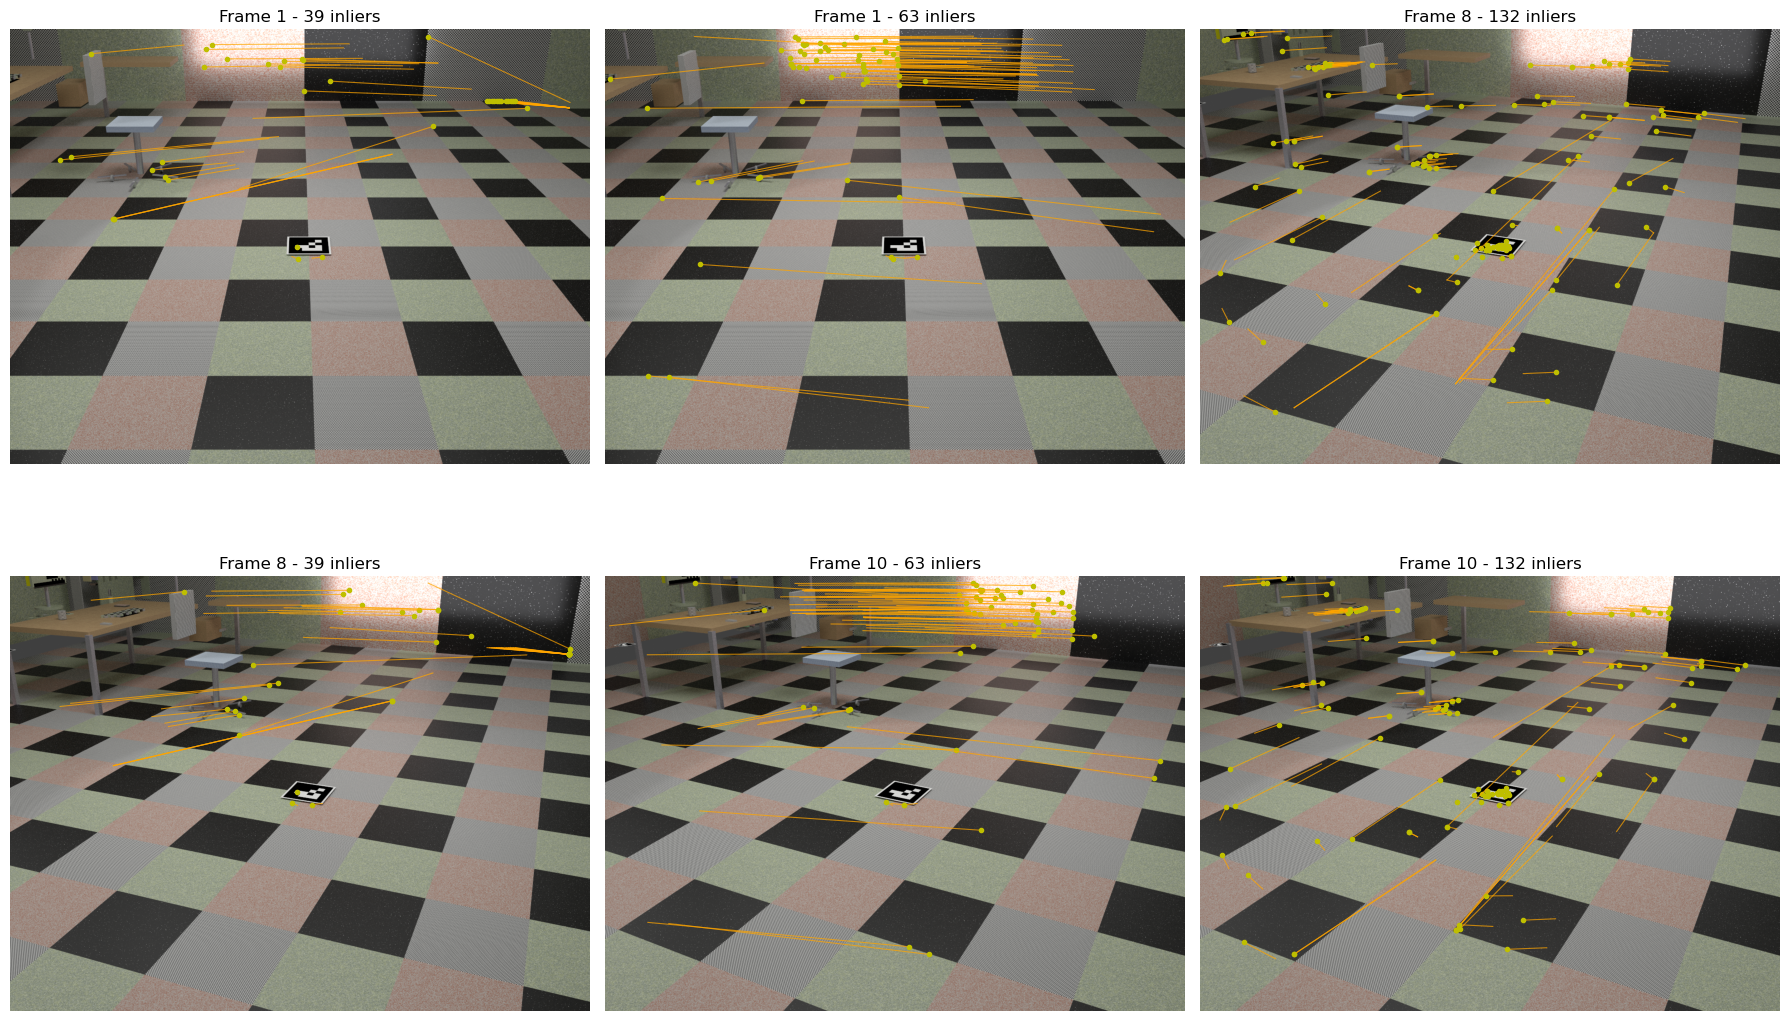

Pair 1-8: 39 inliers
Pair 1-10: 63 inliers
Pair 8-10: 132 inliers


In [18]:
# Visualize RANSAC results for all pairs
plt.figure(figsize=(18, 12))

for i, (pair_name, results) in enumerate(all_ransac_results.items()):
    frame_nums = pair_name.split('-')
    frame_a, frame_b = int(frame_nums[0]), int(frame_nums[1])
    
    # Show matches on first image of pair
    plt.subplot(2, 3, i+1)
    plt.imshow(features[frame_a]['image'])
    for (pa, pb, idx) in results['inliers']:
        x1, y1 = pa[0], pa[1]
        x2, y2 = pb[0], pb[1]
        plt.plot([x1, x2], [y1, y2], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
        plt.plot(x1, y1, 'yo', markersize=3)
    plt.title(f"Frame {frame_a} - {results['count']} inliers")
    plt.axis('off')
    
    # Show matches on second image of pair
    plt.subplot(2, 3, i+4)
    plt.imshow(features[frame_b]['image'])
    for (pa, pb, idx) in results['inliers']:
        x1, y1 = pa[0], pa[1]
        x2, y2 = pb[0], pb[1]
        plt.plot([x1, x2], [y1, y2], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
        plt.plot(x2, y2, 'yo', markersize=3)
    plt.title(f"Frame {frame_b} - {results['count']} inliers")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print summary
for pair_name, results in all_ransac_results.items():
    print(f"Pair {pair_name}: {results['count']} inliers")

In [15]:
# Build projection matrices from ground truth poses
def build_projection_matrix_from_gt(frame_idx, K):
    pose = ground_truth['poses'][frame_idx]['left_camera']
    R = np.array(pose['rotation_matrix'])
    t = np.array(pose['translation']).reshape(-1, 1)
    
    # Convert camera-to-world to world-to-camera
    R_wc = R.T
    t_wc = -R_wc @ t
    
    Rt = np.hstack([R_wc, t_wc])
    return K @ Rt

# Build projection matrices for our three frames
P1 = build_projection_matrix_from_gt(0, K)   # frame 1
P8 = build_projection_matrix_from_gt(7, K)   # frame 8  
P10 = build_projection_matrix_from_gt(9, K)  # frame 10

print("Projection matrix shapes:")
print(f"P1: {P1.shape}")
print(f"P8: {P8.shape}")  
print(f"P10: {P10.shape}")

Projection matrix shapes:
P1: (3, 4)
P8: (3, 4)
P10: (3, 4)


In [19]:
# Triangulate 3D points using ground truth projection matrices
triangulated_points_gt = {}

# Define the projection matrix pairs
projection_pairs = {
    '1-8': (P1, P8),
    '1-10': (P1, P10), 
    '8-10': (P8, P10)
}

# Triangulate for each pair using your RANSAC inliers
for pair_name, (P_a, P_b) in projection_pairs.items():
    if pair_name in all_ransac_results:
        results = all_ransac_results[pair_name]
        
        # Extract clean 2D points from inliers
        clean_pts_a = np.array([pa[:2] for pa, pb, idx in results['inliers']])
        clean_pts_b = np.array([pb[:2] for pa, pb, idx in results['inliers']])
        
        # Triangulate using ground truth projection matrices
        points_4d = cv2.triangulatePoints(P_a, P_b, clean_pts_a.T, clean_pts_b.T)
        points_3d = points_4d[:3] / points_4d[3]
        points_3d = points_3d.T
        
        triangulated_points_gt[pair_name] = points_3d
        print(f"Pair {pair_name}: Triangulated {len(points_3d)} 3D points using ground truth")

total_points = sum(len(points) for points in triangulated_points_gt.values())
print(f"\nTotal 3D points from ground truth: {total_points}")

Pair 1-8: Triangulated 39 3D points using ground truth
Pair 1-10: Triangulated 63 3D points using ground truth
Pair 8-10: Triangulated 132 3D points using ground truth

Total 3D points from ground truth: 234


In [20]:
# Build feature database using frame 1 descriptors as reference
feature_database = []

for pair_name, points_3d in triangulated_points_gt.items():
    if pair_name.startswith('1-'):  # Only use pairs that include frame 1
        frame_nums = pair_name.split('-')
        frame_b = int(frame_nums[1])
        
        # Get the RANSAC results for this pair
        results = all_ransac_results[pair_name]
        
        print(f"Processing pair {pair_name}: {len(points_3d)} 3D points")
        
        for i, (pa, pb, match_idx) in enumerate(results['inliers']):
            # Get the original match to find the descriptor index
            original_matches = all_matches[pair_name][2]  # The raw matches
            
            if match_idx < len(original_matches):
                desc_idx = original_matches[match_idx].queryIdx  # Frame 1 descriptor index
                
                if desc_idx < len(features[1]['descriptors']):
                    descriptor = features[1]['descriptors'][desc_idx]
                    
                    feature_database.append({
                        'descriptor': descriptor,
                        'point_3d': points_3d[i],
                        'source_pair': pair_name,
                        'frame1_coord': pa[:2]
                    })

print(f"Feature database built: {len(feature_database)} entries")
print(f"Descriptor shape: {feature_database[0]['descriptor'].shape if feature_database else 'N/A'}")

Processing pair 1-8: 39 3D points
Processing pair 1-10: 63 3D points
Feature database built: 102 entries
Descriptor shape: (128,)
